In [2]:
include("../Engine/Engine.jl")
using .Engine

using StatsBase, DataFrames
import PyPlot as plt
import Seaborn as sns

In [ ]:
df = load_dataset(Skripal)
df = skripal_dates(df)
df = df[df.partition .== "During campaign", :]

w, u, v, nodes = PreProcessing.compute_IP_graph(df)
I, P, res = PreProcessing.compute_IP_scores(u, v)

plt.figure()
plt.plot(1:length(res), res)
plt.xlabel("Iteration")
plt.ylabel("Residual")
plt.yscale("log")
plt.grid()
# plt.savefig("/Users/cyrilvallez/Desktop/Thesis/Figures/residual.pdf", bbox_inches="tight")

In [3]:
df = load_dataset(Skripal)
df = skripal_dates(df)
df = trust_score(df)
f, _ = all_users()
df = f(df)

,partition,created_at,effective_category,domain
,String,DateTime,String,Array…
1,Before campaign,2018-03-06T23:54:20,tweet,"[""dailymail.co.uk""]"
2,Before campaign,2018-03-06T23:48:38,tweet,"[""standard.co.uk""]"
3,Before campaign,2018-03-06T23:45:44,tweet,"[""nbcnews.com""]"
4,Before campaign,2018-03-06T23:45:16,tweet,"[""aljazeera.com""]"
5,Before campaign,2018-03-06T23:45:00,tweet,"[""nbcnews.com""]"
6,Before campaign,2018-03-06T23:44:13,tweet,"[""bbc.co.uk""]"
7,Before campaign,2018-03-06T23:40:57,tweet,"[""independent.co.uk""]"
8,Before campaign,2018-03-06T23:40:08,tweet,"[""businessinsider.com""]"
9,Before campaign,2018-03-06T23:38:04,tweet,"[""economist.com""]"


In [7]:
# domains = collect(Iterators.flatten(df[df.username .== "ShoebridgeC", :domain]))
domains = collect(Iterators.flatten(df[df.username .== "newsroll", :domain]))
foo = countmap(domains)

Dict{Any, Int64} with 5 entries:
  "tass.com"          => 2
  "rt.com"            => 14
  "pravdareport.com"  => 1
  "globalresearch.ca" => 1
  "sputniknews.com"   => 14

In [ ]:
print()

In [ ]:
df_before = df[df.partition .== "Before campaign", :]
df_before = df_before[df_before.action .== "U", :]
df_during = df[df.partition .== "During campaign", :]
df_during = df_during[df_during.action .== "U", :]
df_after = df[df.partition .== "After campaign", :]
df_after = df_after[df_after.action .== "U", :]

users_TE_before = ["peterpobjecky", "DontDenyThe", "JJorbyn", "wherepond", "shabbirh", "BeeAHoney_", "JuliaPolan", "PakamamaniRenew", "TheUrbanNewz", "londonfredd"]
df_TE_before = df_before[in.(df_before.username, Ref(users_TE_before)), :]

users_JDD_during = ["RT_com", "newsroll", "JJorbyn", "ferozwala", "paris_2015", "tonybrooklyn5", "QueensIceZ", "RLSRUSSIANNEWS", "dwilliam9940", "lisa_alba"]
df_JDD_during = df_during[in.(df_during.username, Ref(users_JDD_during)), :]
users_TE_during = ["TheRealYoG", "ferozwala", "BuggerLePanda", "ProfessorsBlogg", "Arfatweet", "NecktopP", "OldRightie", "RTUKnews", "ali9l9", "zerohedge"]
df_TE_during = df_during[in.(df_during.username, Ref(users_TE_during)), :]

users_JDD_after = ["JudeJack", "HillestadNils", "SQUADDICTS", "starandsixpence", "newsbloktwit", "flyer4life", "jarfizo1", "DJSiri", "Mr_Nick_Nasty", "TacticalFM"]
df_JDD_after = df_after[in.(df_after.username, Ref(users_JDD_after)), :]
users_TE_after = ["Pline999", "Revoche", "SnakeTera", "infidelchloe", "charlievictor16", "Char_lotte777", "LordGamblore", "iccjock06", "StephaniePetri1", "TheUrbanNewz"]
df_TE_after = df_after[in.(df_after.username, Ref(users_TE_after)), :]


dfs = [df_before, nothing, df_TE_before, df_during, df_JDD_during, df_TE_during, df_after, df_JDD_after, df_TE_after]
distributions = []
for df in dfs
    push!(distributions, find_distribution(df, "rt.com"))
end

palette = ["tab:blue", "tab:blue", "tab:blue", "tab:orange", "tab:orange", "tab:orange", "tab:green", "tab:green", "tab:green"]
plt.figure(figsize=(15,5))
sns.violinplot(distributions, width=1., cut=0, scale="width", palette=palette, gridsize=10000)
# plt.yscale("log")

In [ ]:
function find_distribution(df, domain)

    if df == nothing
        return []
    end
    dis = combine(groupby(df, "username"), "domain" => (x -> sum(collect(Iterators.flatten(x)) .== domain)) => "distribution")
    return dis.distribution

end

In [ ]:
df_during = df[df.partition .== "During campaign", :];
df_during = df_during[df_during.action .== "U", :]


domains = collect(Iterators.flatten(df_during.domain))
count = countmap(domains)
prop = proportionmap(domains)

users_JDD = ["RT_com", "newsroll", "JJorbyn", "ferozwala", "paris_2015", "tonybrooklyn5", "QueensIceZ", "RLSRUSSIANNEWS", "dwilliam9940", "lisa_alba"]
df_JDD = df_during[in.(df_during.username, Ref(users_JDD)), :]
domains_JDD = collect(Iterators.flatten(df_JDD.domain))
count_JDD = countmap(domains_JDD)
prop_JDD = proportionmap(domains_JDD)


users_TE = ["TheRealYoG", "ferozwala", "BuggerLePanda", "ProfessorsBlogg", "Arfatweet", "NecktopP", "OldRightie", "RTUKnews", "ali9l9", "zerohedge"]
df_TE = df_during[in.(df_during.username, Ref(users_TE)), :]
domains_TE = collect(Iterators.flatten(df_TE.domain))
count_TE = countmap(domains_TE)
prop_TE = proportionmap(domains_TE)

if !(length(unique(df_JDD.username)) == 10)
    print("issue JDD")
end
if !(length(unique(df_TE.username)) == 10)
    print("issue TE")
end

println("rt :")
println("All : $(count["rt.com"] / length(unique(df_during.username)))")
println("JDD : $(count_JDD["rt.com"] / length(unique(df_JDD.username)))")
println("TE : $(count_TE["rt.com"] / length(unique(df_TE.username)))")

println("")
println("sputnik :")
println("All : $(count["sputniknews.com"] / length(unique(df_during.username)))")
println("JDD : $(count_JDD["sputniknews.com"] / length(unique(df_JDD.username)))")
println("TE : $(count_TE["sputniknews.com"] / length(unique(df_TE.username)))")

In [ ]:
df_before = df[df.partition .== "Before campaign", :];
df_before = df_before[df_before.action .== "U", :]


domains = collect(Iterators.flatten(df_before.domain))
count = countmap(domains)
prop = proportionmap(domains)


users_TE = ["peterpobjecky", "DontDenyThe", "JJorbyn", "wherepond", "shabbirh", "BeeAHoney_", "JuliaPolan", "PakamamaniRenew", "TheUrbanNewz", "londonfredd"]
df_TE = df_before[in.(df_before.username, Ref(users_TE)), :]
domains_TE = collect(Iterators.flatten(df_TE.domain))
count_TE = countmap(domains_TE)
prop_TE = proportionmap(domains_TE)

if !(length(unique(df_TE.username)) == 10)
    print("issue TE")
end

println("rt :")
println("All : $(count["rt.com"] / length(unique(df_during.username)))")
println("TE : $(count_TE["rt.com"] / length(unique(df_TE.username)))")

println("")
println("sputnik :")
println("All : $(count["sputniknews.com"] / length(unique(df_during.username)))")
println("TE : $(count_TE["sputniknews.com"] / length(unique(df_TE.username)))")

In [ ]:
df_after = df[df.partition .== "After campaign", :];
df_after = df_after[df_after.action .== "U", :]


domains = collect(Iterators.flatten(df_after.domain))
count = countmap(domains)
prop = proportionmap(domains)

users_JDD = ["JudeJack", "HillestadNils", "SQUADDICTS", "starandsixpence", "newsbloktwit", "flyer4life", "jarfizo1", "DJSiri", "Mr_Nick_Nasty", "TacticalFM"]
df_JDD = df_after[in.(df_after.username, Ref(users_JDD)), :]
domains_JDD = collect(Iterators.flatten(df_JDD.domain))
count_JDD = countmap(domains_JDD)
prop_JDD = proportionmap(domains_JDD)


users_TE = ["Pline999", "Revoche", "SnakeTera", "infidelchloe", "charlievictor16", "Char_lotte777", "LordGamblore", "iccjock06", "StephaniePetri1", "TheUrbanNewz"]
df_TE = df_after[in.(df_after.username, Ref(users_TE)), :]
domains_TE = collect(Iterators.flatten(df_TE.domain))
count_TE = countmap(domains_TE)
prop_TE = proportionmap(domains_TE)

if !(length(unique(df_JDD.username)) == 10)
    print("issue JDD")
end
if !(length(unique(df_TE.username)) == 10)
    print("issue TE")
end

println("rt :")
println("All : $(count["rt.com"] / length(unique(df_during.username)))")
println("JDD : $(count_JDD["rt.com"] / length(unique(df_JDD.username)))")
println("TE : $(count_TE["rt.com"] / length(unique(df_TE.username)))")

println("")
println("sputnik :")
println("All : $(count["sputniknews.com"] / length(unique(df_after.username)))")
println("JDD : $(count_JDD["sputniknews.com"] / length(unique(df_JDD.username)))")
println("TE : $(count_TE["sputniknews.com"] / length(unique(df_TE.username)))")

In [ ]:
df = load_dataset(RandomDays)
df = no_partition(df)
df = trust_score(df)
f, _ = all_users()
df = f(df)

df = unique(df, :username)

plot_actor_wordcloud(df, save=true, filename="../../Figures/Datasets/Random_all_users/wordcloud.svg")

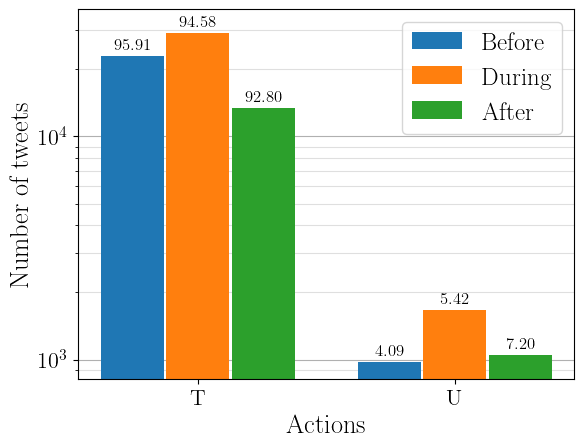

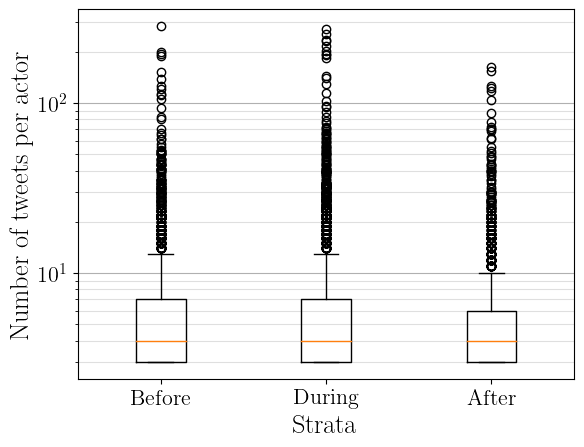

In [5]:
df = load_dataset(COP27)
df = cop_27_dates(df)
df = trust_score(df)
f, _ = all_users()
df = f(df)


plot_action_frequency(df, save=true, filename="../../Figures/COP27/Dataset/action_frequency.pdf")
plot_actor_frequency(df, save=true, filename="../../Figures/COP27/Dataset/actor_frequency.pdf");

In [ ]:
df = load_dataset(RandomDays)
df = no_partition(df)
df = trust_score(df)
f, _ = all_users()
df = f(df)


plot_actor_frequency(df, save=false, filename="../../Figures/Random/Dataset/actor_frequency.pdf")
ax = plt.gca()
ax.set_xticks([1], [""])
plt.xlabel("RandomDays dataset")
plt.savefig("../../Figures/Random/Dataset/actor_frequency.pdf", bbox_inches="tight")


plot_action_frequency(df, save=false, filename="../../Figures/Random/Dataset/actor_frequency.pdf")
ax = plt.gca()
ax.get_legend().remove()
plt.savefig("../../Figures/Random/Dataset/action_frequency.pdf", bbox_inches="tight")

In [ ]:
df = load_dataset(Skripal)
df = skripal_dates(df)
df = trust_score(df)
f, _ = IP_scores()

df1 = df[df.action .== "U", :]
df2 = df[df.action .== "T", :]

df1 = f(df1)
df2 = f(df2)


partitions = sort(unique(df.partition))
dfs_U = []
dfs_T = []

for partition in partitions
    useful1 = df1[df1.partition .== partition, :]
    useful1 = unique(useful1, :username)[:, ["username", "partition", "I_score", "P_score"]]
    useful1."I score_rank" = ordinalrank(useful1.I_score, rev=true)
    sort!(useful1, "I score_rank")
    push!(dfs_U, useful1)

    useful2 = df2[df2.partition .== partition, :]
    useful2 = unique(useful2, :username)[:, ["username", "partition", "I_score", "P_score"]]
    useful2."I score_rank" = ordinalrank(useful2.I_score, rev=true)
    sort!(useful2, "I score_rank")
    push!(dfs_T, useful2)
end

In [ ]:
dfs_U[3]

In [ ]:
dfs_T[3]

In [ ]:
include("../Engine/Engine.jl")
using .Engine

using StatsBase, DataFrames
import PyPlot as plt
import Seaborn as sns

In [ ]:
igg = InfluenceGraphGenerator(JointDistanceDistribution, threshold=1, limit="x->minimum(x)/4")

tot = 0
for i = 1:1000
    # x = rand(0:1, 150)
    # y = rand(0:1, 150)

    x = sample(0:1, AnalyticWeights([0.9, 0.1]), 150)
    y = sample(0:1, AnalyticWeights([0.9, 0.1]), 150)

    x = Sensors.standardize(x)
    y = Sensors.standardize(y)
    tot += igg.causal_function(x,y)
end

tot

In [ ]:
using ArgParse, StatsBase
import Random
Random.seed!(1)


# function draw_series(N, M = 150, min_ = 3, weights = nothing)
#     if isnothing(weights)
#         weights = AnalyticWeights([0.96, 0.03, 0.003, 0.001, 0.001])
#     end

#     sample_ = [sample(0:4, weights, M) for i = 1:N]
#     for i = 1:N
#         if sum(sample_[i]) < min_
#             while sum(sample_[i]) < min_
#                 sample_[i] = sample(0:4, weights, M)
#             end
#         end
#     end

#     return sample_

# end

function draw_series(N, M = 150, min_ = 3, weights = nothing)

    if isnothing(weights)
        weights = AnalyticWeights([0.96, 0.03, 0.003, 0.001, 0.001])
    end

    sample_ = [sample(0:1, AnalyticWeights([0.9, 0.1]), M) for i = 1:N]
    for i = 1:N
        if sum(sample_[i]) < min_
            while sum(sample_[i]) < min_
                sample_[i] = sample(0:1, AnalyticWeights([0.9, 0.1]), M)
            end
        end
    end

    return sample_
    
end


N = 10
N_redo_all = 5
N_redo_surro = 5

thresholds2 = [1, 1e-1, 5e-2, 1e-2, 5e-3, 1e-3, 5e-4, 1e-4]
limits2 = ["x->1000000", "x->quantile(x, 0.5)", "x->quantile(x, 0.25)", "x->quantile(x, 0.1)", "x->quantile(x, 0)", "x->quantile(x, 0)/2", "x->quantile(x, 0)/4", "x->quantile(x, 0)/6"]

result2 = Matrix{Matrix{Float64}}(undef, length(limits2), length(thresholds2))
for i in eachindex(result2)
    result2[i] = Matrix{Float64}(undef, N_redo_all, N_redo_surro)
end

# Random seeds
seeds_all = sample(1:10000, N_redo_all, replace=false)
seeds_surro = sample(1:10000, N_redo_surro, replace=false)

function run(result2)
    for (k, seed_all) in enumerate(seeds_all)

        Random.seed!(seed_all)
        X = draw_series(N)
        Y = draw_series(N)

        for (l, seed_surro) in enumerate(seeds_surro)

            for (i, limit) in enumerate(limits2)
                for (j, threshold) in enumerate(thresholds2)

                    Random.seed!(seed_surro)
                    igg = InfluenceGraphGenerator(JointDistanceDistribution, threshold=threshold, limit=limit)
                    tot = 0

                    for idx = 1:N
                        x = Sensors.standardize(X[idx])
                        y = Sensors.standardize(Y[idx])
                        a = igg.causal_function(x, y)
                        # try
                        #     if igg.causal_function(x, y) == 1
                        #         tot += 1
                        #     end  
                        # catch
                        #     Foo1 = x
                        #     Foo2 = y
                        #     # tot += igg.causal_function(x, y)
                        #     # return Foo1, Foo2, limit, threshold
                        # end
                    end

                    result2[i,j][k,l] = tot/N

                end
            end

        end

    end

    return result2

end

Foo1 = nothing
Foo2 = nothing
T = nothing
L = nothing

for (k, seed_all) in enumerate(seeds_all)

    Random.seed!(seed_all)
    X = draw_series(N)
    Y = draw_series(N)

    for (l, seed_surro) in enumerate(seeds_surro)

        for (i, limit) in enumerate(limits2)
            for (j, threshold) in enumerate(thresholds2)

                Random.seed!(seed_surro)
                igg = InfluenceGraphGenerator(JointDistanceDistribution, threshold=threshold, limit=limit)
                tot = 0

                for idx = 1:N
                    x = Sensors.standardize(X[idx])
                    y = Sensors.standardize(Y[idx])
                    # a = igg.causal_function(x, y)
                    try
                        if igg.causal_function(x, y) == 1
                            tot += 1
                        end  
                    catch
                        Foo1 = x
                        Foo2 = y
                        L = limit
                        T = threshold
                        @goto fdp
                        # tot += igg.causal_function(x, y)
                        # return Foo1, Foo2, limit, threshold
                    end
                end

                result2[i,j][k,l] = tot/N

            end
        end

    end
    @label fdp
end


# a, b, L, T = run(result2)


In [ ]:
igg = InfluenceGraphGenerator(JointDistanceDistribution, threshold=10000, limit="x->minimum(x)/4")
igg.causal_function(Foo1, Foo2)

In [ ]:
using Distances

measure(x,y) = jdd(x, y, distance_metric=SqEuclidean(), B=10, D=5, τ=1)

x = Foo1
y = Foo2
A = nothing
B = nothing

generator = surrogenerator(x, RandomShuffle())
surro_values = Vector(undef, 100)
for i = 1:100
    x = generator()
    surro_values[i] = measure(x, y)
    # if isnan(surro_values[i])
        # A = copy(x)
        # B = copy(y)
    # end
end

In [ ]:
ttests = OneSampleTTest.(surro_values)
pvals = pvalue.(ttests, tail=:right)

indices = findall(isnan.(pvals))

In [ ]:
# ttests[indices[6]]
surro_values[indices[10]]

In [ ]:
t = OneSampleTTest([1,1,1,1,1,1,1], 1)
# pvalue(t)

In [ ]:
filter()

In [ ]:
Vector{Int64} <: AbstractVector{T} where T<:Real

In [ ]:
surro_values

In [ ]:
sum(isnan.(surro_values))

In [ ]:
measure(A,B)

In [ ]:
print(A)

In [ ]:
using Distances: Euclidean
using Distances: pairwise
using DelayEmbeddings: genembed
using HypothesisTests

js = ([1 for i = 1:5]...,)
τs = (collect(0:-1:-(5-1)*1)...,)
Ex = genembed(A, τs, js)
Ey = genembed(B, τs, js)
Dx = pairwise(Euclidean(), Ex.data)
Dy = pairwise(Euclidean(), Ey.data)

fDx = filter(dx -> dx .> 0, Dx)
fDy = filter(dy -> dy .> 0, Dy)
Dx_min, Dx_max = minimum(fDx), maximum(fDx)
Dy_min, Dy_max = minimum(fDy), maximum(fDy)

normDx = rank_transformation(vec(Dx)) ./ length(Dx)
normDy = rank_transformation(vec(Dy)) ./ length(Dy)

In [ ]:
Dx

In [ ]:
Dx_max

In [ ]:
igg = InfluenceGraphGenerator(JointDistanceDistribution, threshold=T, limit=L)
igg.causal_function(Foo1, Foo2)

In [ ]:
folder = "/Users/cyrilvallez/Desktop/Thesis/Data/Twitter/Skripal_processed_lightweight"
files = [file for file in readdir(folder, join=true) if occursin(".json", file)]

df1 = vcat([Helpers.load_json(file) for file in files]...)
df2 = Helpers.load_json("/Users/cyrilvallez/Desktop/Thesis/Data/BrandWatch/Skripal/skripal_clean_lightweight.json")

In [ ]:
plt.figure()
plt.hist(df1.created_at, bins=100)
xloc, xlabels = plt.xticks()
plt.xticks(xloc, xlabels, rotation="vertical");


In [ ]:
plt.figure()
plt.hist(df2.created_at, bins=100)
xloc, xlabels = plt.xticks()
plt.xticks(xloc, xlabels, rotation="vertical");

In [ ]:
df3 = load_dataset(Skripal)
df3 = skripal_dates(df3)


plt.figure()
plt.hist(df3.created_at, bins=100)
xloc, xlabels = plt.xticks()
plt.xticks(xloc, xlabels, rotation="vertical");

In [ ]:
[0.9*0.15^i for i = 0:4]

In [ ]:
sum(weights)

In [ ]:
using StatsBase

weights = AnalyticWeights([0.965, 0.03, 0.003, 0.001, 0.001])
b = AnalyticWeights(weights)

foo = [sample(0:4, b, 150) for i = 1:10000]
test = [sum(a) for a in foo]

plt.figure()
plt.boxplot(test);

In [ ]:
function draw_series(N, M = 150, weights = nothing)
    if isnothing(weights)
        weights = AnalyticWeights([0.965, 0.03, 0.003, 0.001, 0.001])
    end

    sample_ = [sample(0:4, weights, M) for i = 1:N]
    for i = 1:N
        if sum(sample_[i]) < 3
            while sum(sample_[i]) < 3
                sample_[i] = sample(0:4, weights, M)
            end
        end
    end

    return sample_

end

foo = draw_series(10000)
test = [sum(a) for a in foo]

plt.figure()
plt.boxplot(test);

In [ ]:
10000*100*2.5e-3/3600*25*8

In [ ]:
df = load_dataset(Skripal)

In [ ]:
df = load_dataset(Skripal)
df = skripal_dates(df)
df = trust_score(df)
f, _ = all_users()
df = f(df)

plot_action_frequency(df, save=true, log=false, filename="../../Figures/Datasets/Skripal_all_users/action_frequency.pdf");

In [ ]:


df = skripal_dates(df)
f, _ = all_users()
df = f(df)

combine(groupby(df, "partition"), "username" => (x->length(unique(x))) => "count")

In [ ]:
using PyPlot: @L_str

result = load_data("/Users/cyrilvallez/Desktop/Thesis/Results/Find_thresholds/N_1000_JDD.jld2")
labels = ["None", "Q(0.5)", "Q(0.25)", "Q(0.1)", "min", "min/2", "min/4", "min/6"]
thresholds = [1, 1e-1, 5e-2, 1e-2, 5e-3, 1e-3, 5e-4, 1e-4]


mean_value = Matrix{Float64}(undef, size(result))
for i in eachindex(result)
    mean_value[i] = mean(result[i])
end

if any(mean_value .== 0)
    vmin = minimum(mean_value[mean_value .!= 0])*0.5
else
    vmin = minimum(mean_value)
end

plt.figure(figsize=[6.4, 4.8])
sns.heatmap(mean_value, annot=true, cmap="rocket_r", norm=plt.matplotlib.colors.LogNorm(vmin=vmin, clip=true))
plt.xlabel("p-value")
plt.ylabel(L"S(\cdot)")
xloc, xlabels = plt.xticks()
plt.xticks(xloc, thresholds)
yloc, ylabels = plt.yticks()
plt.yticks(yloc, labels, rotation="horizontal")
xloc, xlabels = plt.xticks()
plt.xticks(xloc, ["1.0", "1e-1", "5e-2", "1e-2", "5e-3", "1e-3", "5e-4", "1e-4"])
plt.savefig("/Users/cyrilvallez/Desktop/Thesis/Figures/Thresholds/N_1000_JDD.pdf", bbox_inches="tight")
plt.gcf();

In [ ]:
import Seaborn as sns

result = load_data("/Users/cyrilvallez/Desktop/Thesis/Results/Find_thresholds/new_test2_TE.jld2")
labels = ["None", "Q(0.5)", "Q(0.75)", "Q(0.9)", "max", "2max", "4max"]
thresholds = 0:0.1:0.6


mean_value = Matrix{Float64}(undef, size(result))
for i in eachindex(result)
    mean_value[i] = mean(result[i])
end

if any(mean_value .== 0)
    vmin = minimum(mean_value[mean_value .!= 0])*0.5
else
    vmin = minimum(mean_value)
end

plt.figure(figsize=[6.4, 4.8].*1.2)
sns.heatmap(mean_value, annot=true, cmap="rocket_r", fmt=".2g", norm=plt.matplotlib.colors.LogNorm(vmin=vmin, clip=true))
plt.xlabel("Threshold")
plt.ylabel("Limit value")
xloc, xlabels = plt.xticks()
plt.xticks(xloc, thresholds)
yloc, ylabels = plt.yticks()
plt.yticks(yloc, labels, rotation="horizontal")
plt.gcf();

In [ ]:
cop26 = load_dataset(COP26)
ranks = get_all_ranks(cop26, cop_26_dates)

graphs, cascades, df = load_data("/home/ubuntu/Thesis/Results/JDD_all_users/COP26/data.jld2");

In [ ]:
# plt.figure()
# sns.heatmap(mean_value, annot=true, cmap="rocket_r")
# plt.xlabel("Threshold")
# plt.ylabel("Limit value")
# xloc, xlabels = plt.xticks()
# plt.xticks(xloc, thresholds)
# yloc, ylabels = plt.yticks()
# plt.yticks(yloc, labels, rotation="horizontal")
# plt.savefig(path * "_TE.pdf", bbox_inches="tight")
# plt.gcf()



In [ ]:
ranks[end-20:end, :]

In [ ]:
using Graphs, SimpleWeightedGraphs
edge_type = "Any Edge"
N_biggest = 20
cuttoff = 0

between, between_actors = betweenness_centralities2(graphs, df, cuttoff=cuttoff, edge_type=edge_type)
in_, in_actors = indegree_centralities2(graphs, df, cuttoff=cuttoff, edge_type=edge_type)
out, out_actors = outdegree_centralities2(graphs, df, cuttoff=cuttoff, edge_type=edge_type)

between_actors[3][1:N_biggest]

In [ ]:
out_actors[3][1:N_biggest]

In [ ]:
# ranks.tweet_rank = ordinalrank(ranks.tweet_count, rev=true)
foo = ranks[ranks.partition .== "During COP26", ["username", "tweet_rank", "tweet_count"]]
sort!(foo, :tweet_rank)

In [ ]:
file1 = "/home/ubuntu/Thesis/Results/JDD_all_users/COP26-After_COP26/data.jld2"
file2 = "/home/ubuntu/Thesis/Results/JDD_all_users/COP26-Before_COP26/data.jld2"
file3 = "/home/ubuntu/Thesis/Results/JDD_all_users/COP26-During_COP26/data.jld2"

df = load_dataset(COP26)

# Define partitions, actions and actors
partitions = cop_26_dates
actions = trust_score
actors = all_users(by_partition=true, min_tweets=3)
agents = PreProcessingAgents(partitions, actions, actors)

df = preprocessing(df, agents)

graph1, cascade1, _ = load_data(file1)
graph2, cascade2, _ = load_data(file2)
graph3, cascade3, _ = load_data(file3)

graph1 = graph1[1]
cascade1 = cascade1[1]
graph2 = graph2[1]
cascade2 = cascade2[1]
graph3 = graph3[1]
cascade3 = cascade3[1]

graphs = [graph1, graph2, graph3]
cascades = [cascade1, cascade2, cascade3]

# mkpath("/home/ubuntu/Thesis/Results/JDD_all_users/COP26")
# save_data(graphs, cascades, df, "/home/ubuntu/Thesis/Results/JDD_all_users/COP26/data.jld2")

In [ ]:
filename1 = "/Users/cyrilvallez/Desktop/Thesis/Data/Twitter/Skripal_processed_lightweight"
filename2 = "/Users/cyrilvallez/Desktop/Thesis/Data/BrandWatch/Skripal/skripal_clean_lightweight.json"

datafiles1 = [file for file in readdir(filename1, join=true) if occursin(".json", file)]

df1 = vcat([Helpers.load_json(file) for file in datafiles1]...)
df3 = Helpers.load_json(filename2)

df1 = df1[:, Not("sentiment")]

sum_ = 0
for i = 1:length(df1[:, 1])
    if df1[1,:] in eachrow(df3)
        sum_ += 1
    end
end
sum_

In [ ]:
using Languages
import CSV
using DataFrames

detector = LanguageDetector()

df2 = Helpers.load_json("/Users/cyrilvallez/Desktop/Thesis/Data/BrandWatch/Skripal/skripal_clean.json")
news = CSV.read("/Users/cyrilvallez/Desktop/Thesis/Data/newsguard_full_table_clean.csv", DataFrame)

isin = (x,y) -> ismissing(x) ? missing : any([any(elem .== y) for elem in x])
mask = isin.(df2.domain, Ref(news.domain))
df2 = df2[mask, :]

df2.lang = detector.(df2.text)

In [ ]:
using StatsBase
include("../Engine/Engine.jl")
using .Engine
import PyPlot as plt
import Seaborn as sns

In [ ]:
df = load_dataset(Skripal)
df = skripal_dates(df);
df = trust_score(df);
f, _ = IP_scores(by_partition=false)
df = f(df);

x = df."username"
indices = unique(i -> x[i], 1:length(x))
# Get unique usernames and corresponding follower_count
users = x[indices]
I = df.I_score[indices]
P = df.P_score[indices]

sorting = sortperm(I, rev=true)
users = users[sorting]
P = P[sorting]
I = I[sorting]

print(users[1:30])

In [ ]:
filename = "/Users/cyrilvallez/Desktop/Thesis/Data/Twitter/Skripal_processed_lightweight"
files = [file for file in readdir(filename, join=true)]
frames = [Helpers.load_json(file) for file in files]
df = vcat(frames...)


df = skripal_dates(df);
df = trust_score(df);
f, _ = IP_scores(by_partition=false)
df = f(df);

x = df."username"
indices = unique(i -> x[i], 1:length(x))
# Get unique usernames and corresponding follower_count
users = x[indices]
I = df.I_score[indices]
P = df.P_score[indices]

sorting = sortperm(I, rev=true)
users = users[sorting]
P = P[sorting]
I = I[sorting]

print(users[1:30])

In [ ]:
print(users[1:50])

In [ ]:
df2 = load_dataset(COP26)
df2 = cop_26_dates(df2)
f, _ = IP_scores(actor_number="all_positive", aggregate_size=100000000)
df2 = f(df2)

combine(groupby(df2, "partition"), "actor" => (x->length(unique(x))) => "count")

In [ ]:
df2 = load_dataset(COP26)
df2 = cop_26_dates(df2)
f, _ = IP_scores(actor_number="all", aggregate_size=100000000)
df2 = f(df2)

combine(groupby(df2, "partition"), "actor" => (x->length(unique(x))) => "count")

In [ ]:
x = df."username"
indices = unique(i -> x[i], 1:length(x))
# Get unique usernames and corresponding follower_count
users = x[indices]
I = df.I_score[indices]
P = df.P_score[indices]

sorting = sortperm(I, rev=true)
users = users[sorting]
P = P[sorting]
I = I[sorting]

In [ ]:
x = rand(200)
y = rand(200)




In [ ]:
sum(df2.I_score .> 0)

In [ ]:
import PyPlot as plt

plt.hist(df2.created_at, bins=42)

df = co

In [ ]:
plot_action_frequency(df)

In [ ]:
x = rand(0:1, 200);

In [ ]:
using CausalityTools
import Random
Random.seed!(12)

surros = []
generator = surrogenerator(x, RandomShuffle())
for i = 1:100
    push!(surros, copy(generator()))
end

generator = surrogenerator(x, RandomShuffle())
for i = 1:100
    push!(surros, copy(generator()))
end

In [ ]:
using Dates

DateTime(2018, 04, 08, 01, 00, 00) > Date(2018, 04, 8)

In [ ]:
Random.seed!(12)

surros2 = []
generator = surrogenerator(x, RandomShuffle())
for i = 1:100
    push!(surros2, copy(generator()))
end

generator = surrogenerator(x, RandomShuffle())
for i = 1:100
    push!(surros2, copy(generator()))
end

In [ ]:
# f1, _ = IP_scores(by_partition=true, actor_number="all")
f2, _ = all_users(by_partition=true)

# df1 = f1(df)
df2 = f2(df);

In [ ]:
unique(df2.username)

In [ ]:
df1[:, Not(["I_score", "P_score", "retweet_from"])] == df2[:, Not(["tweet_count", "retweet_from"])]

In [ ]:
names(df1)

In [ ]:
f1, _ = IP_scores(by_partition=true, min_tweets=3)
df1 = f1(df)
df1 = df1[:, Not("retweet_from")]
df1 = select(df1, sort(names(df1)));

In [ ]:
combine(groupby(df1, "partition"), "username" => (x->length(unique(x))) => "count")

In [ ]:
f2, _ = IP_scores(by_partition=false, min_tweets=3)

dfs = []
for partition in unique(df.partition)
    push!(dfs, f2(df[df.partition .== partition, :]))
end
df2 = vcat(dfs...)[:, Not("retweet_from")]
df2 = select(df2, sort(names(df2)));

In [ ]:
df1 == df2

In [ ]:
using BenchmarkTools
using CausalityTools

igg = InfluenceGraphGenerator(Engine.JointDistanceDistribution, surrogate=nothing)

f = (x,y) -> pvalue(jdd(OneSampleTTest, x, y, B=10, D=5, τ=1, μ0=0.0), tail=:right) < 0.001 ? 1 : 0
f2 = (x,y) -> igg.causal_function(x,y)

x = rand(600)
y = rand(600)

@btime f2(x,y)

In [ ]:
regex = r"^AGG[0-9]+:"
a = "AGG1678934: joeoepzocnjocz    dveonoze^12"
if occursin(regex, a)
    print("cool")
else
    print("prout")
end

In [ ]:
df1 = transform(groupby(df1, "username"), "effective_category" => (x -> sum(x .== "tweet")) => "tweet_count")
df2 = transform(groupby(df2, "username"), "effective_category" => (x -> sum(x .== "tweet")) => "tweet_count")
df3 = transform(groupby(df3, "username"), "effective_category" => (x -> sum(x .== "tweet")) => "tweet_count")

In [ ]:
df1 = df1[df1.tweet_count .>= 3, :]
df2 = df2[df2.tweet_count .>= 3, :]
df3 = df3[df3.tweet_count .>= 3, :]

In [ ]:
length(unique(df2.username))

In [ ]:
plot_action_frequency(df2)

In [ ]:
length(unique(df2.username))

In [ ]:
tweet_count = combine(groupby(tweeters, "username"), "created_at" => length => "count")
tweet_count = tweet_count[tweet_count.count .>= 3, :]
nodes = tweet_count.username

In [ ]:
"GretaThunberg" in nodes

In [ ]:
using Dates

df = load_dataset(COP26)

df = df[.~ismissing.(df."domain"), :]
if eltype(df."created_at") == String
    to_datetime = x -> DateTime(split(x, '.')[1], "yyyy-mm-ddTHH:MM:SS")
    df."created_at" = to_datetime.(df."created_at")
end

df = PreProcessing.cop_26_dates(df)
df = PreProcessing.trust_score(df)
df = transform(groupby(df, "username"), "created_at" => length => "count")

tweeters = df[df.effective_category .== "tweet", :]
retweeters = df[df.effective_category .== "retweet", :]

bad_df = df[df.action .== "U", :]
good_df = df[df.action .== "T", :]

weights, u, v, nodes = PreProcessing.IP_graph(df, min_tweets=3)

I, P, residuals = PreProcessing.IP_scores(u, v)

# Sort in the order of most influence
sorting = sortperm(I, rev=true)
nodes = nodes[sorting]
I = I[sorting]
P = P[sorting]

# Extract dataframes of 500 most influentials according to I score
isin = (x,y) -> x in y
influentials = tweeters[isin.(tweeters.username, Ref(nodes[1:500])), :]
foo = combine(groupby(influentials, "username"), "action" => (x -> sum(x .== "U")) => "U_count")

bad_users = foo.username[foo.U_count .> 0]
bad_users_rank = [findall(user .== nodes) for user in bad_users];

In [ ]:
nodes_bad[1:20]

In [ ]:
# I_normal = I
# P_normal = P
# nodes_normal = nodes

test_normal = nodes_normal[I_normal .> 0];

In [ ]:
# I_bad = I
# P_bad = P
# nodes_bad = nodes

test_bad = nodes_bad[I_bad .> 0];

In [ ]:
a = [[1, 2], [3, 4]]

In [ ]:
foo = @view a[1]

In [ ]:
foo2 = a[2]

In [ ]:
foo[1]

In [ ]:
a[1][1] = 2
a

In [ ]:
isin = (x,y) -> x in y
# sum(isin.(nodes_bad[1:500], Ref(nodes_normal[1:500])))

sum(isin.(test_bad, Ref(test_normal))) 

In [ ]:
sum(I_normal .> 0)

In [ ]:
(12200 - 500) / 100

In [ ]:
sorting = sortperm(P, rev=true)
nodes = nodes[sorting]
I = I[sorting]
P = P[sorting]

In [ ]:
nodes

In [ ]:
I0 = I .== 0
P0 = P .== 0

I1 = I .!= 0
P1 = P .!= 0;

# sort(I0) == sort(P1)

In [ ]:
sum(I1 .&& P0)

In [ ]:
sum(I1 .|| P1) / length(I0)

In [ ]:
I

In [ ]:
nodes

In [ ]:
test = tweeters[tweeters.action .== "U", :]
test = transform(groupby(test, "username"), "created_at" => length => "Ucount")

length(unique(test[test.Ucount .>= 2, "username"]))

In [ ]:
nodes[123]

In [ ]:
length(residuals)

In [ ]:
res_ = residuals
plt.figure()
plt.plot(1:length(res_), res_)
plt.yscale("log")


In [ ]:
initial_actors = unique(test[ismissing.(test.rt_from), "username"])
counter = []

rts = test[.!ismissing.(test.rt_from), :]
# mapping = countmap(rts)
# transform(groupby(df, "username"), "created_at" => length => "tweet_count")

for (i, a) in enumerate(initial_actors)
    indices = findall(rts.rt_from .== a)
    push!(counter, rts.username[indices])
    # counter[i] = sum(rts.rt_from .== a)
end

In [ ]:
N = [length(i) for i in counter]
sorting = sortperm(N, rev=true)
N = N[sorting]
initial_actors = initial_actors[sorting]
counter = counter[sorting]

In [ ]:
counter[1]

In [ ]:
initial_actors[1:30]

In [ ]:
initial_actors = unique(test[ismissing.(test.rt_from), "username"]);

In [ ]:
using BenchmarkTools

counter = []

@btime begin
    indices = findall(rts.rt_from .== initial_actors[1])
    push!(counter, rts.username[indices])
end

In [ ]:
# foo = test[test.category .== Ref(["tweeted"]), :]
# foo = transform(groupby(foo, "username"), "created_at" => length => "tweet_count")
# foo = foo[foo.tweet_count .>= 1, :]
# length(unique(foo.username))


initial_actors = unique(test[.ismissing.(test.rt_from), "username"])

In [ ]:
sum(.!ismissing.(test.rt_from))

In [ ]:
foo = test[startswith.(test.text, Ref("RT @")) .&& test.category .!= Ref(["retweeted"]), :]

In [ ]:
show(foo, allcols=true)

In [ ]:
find_user(test.text[1])

In [ ]:
length(unique(test.username))

In [ ]:
sum(test.category .== Ref(["quoted"]))

In [ ]:
followers[500]

In [ ]:
sum(followers .== 0)

In [ ]:
261259/50

## DECREASE BINS LOGARITHMICALLY

In [ ]:
25929^2/520^2*10/60/60

In [ ]:
sum(0 .< followers .< 50)

In [ ]:
sum(followers .== 0)

In [ ]:
sum(followers .> 500000)

In [ ]:
test = collect(1:10)
sorting = sortperm(test, rev=true)
test[sorting]